In [1]:
suppressWarnings(suppressPackageStartupMessages(library(ggplot2)))
suppressWarnings(suppressPackageStartupMessages(library(platetools)))
suppressWarnings(suppressPackageStartupMessages(library(gridExtra)))
suppressWarnings(suppressPackageStartupMessages(library(cowplot)))
suppressWarnings(suppressPackageStartupMessages(library(viridis)))
suppressWarnings(suppressPackageStartupMessages(library(argparse)))
suppressWarnings(suppressPackageStartupMessages(library(patchwork)))
suppressWarnings(suppressPackageStartupMessages(library(arrow)))
suppressWarnings(suppressPackageStartupMessages(library(dplyr)))

In [2]:
# Set the path to the index file
index_file_path_PBMC <- file.path(
    "../",
    "../",
    "../",
    "4.sc_Morphology_Neural_Network_MLP_Model/0.hyperparameter_optimization/indexes/PBMC/multi_class/MultiClass_MLP_data_split_indexes.tsv"
)
index_file_path_SHSY5Y <- file.path(
    "../",
    "../",
    "../",
    "4.sc_Morphology_Neural_Network_MLP_Model/0.hyperparameter_optimization/indexes/SHSY5Y/multi_class/MultiClass_MLP_data_split_indexes.tsv"
)
# load the index file
index_file_PBMC <- read.table(
    file = index_file_path_PBMC,
    sep = "\t",
    header = TRUE,
    stringsAsFactors = FALSE
)
index_file_SHSY5Y <- read.table(
    file = index_file_path_SHSY5Y,
    sep = "\t",
    header = TRUE,
    stringsAsFactors = FALSE
)


In [3]:
# create the figure directory if it does not exist
figure_dir <- file.path(
    "../",
    "figures"
)
if (!dir.exists(figure_dir)) {
    dir.create(figure_dir)
}

In [4]:
# sort the index file by labeled_data_index
index_file_PBMC <- index_file_PBMC[order(index_file_PBMC$labeled_data_index),]
head(index_file_PBMC,2)
index_file_SHSY5Y <- index_file_SHSY5Y[order(index_file_SHSY5Y$labeled_data_index),]
head(index_file_SHSY5Y,2)


,labeled_data_index,label
,<int>,<chr>
1764999,0,test
1765000,1,test


,labeled_data_index,label
,<int>,<chr>
162707,0,val
60783,1,train


In [5]:
# set path to the PBMC metadata file
metadata_file_path_PBMC <-file.path(
    "..",
    "..",
    "..",
    "data",
    "PBMC_preprocessed_sc_norm.parquet"
)
# load the metadata file via arrow 
# metadata_file <- arrow::read_parquet(metadata_file_path)

# load via arrow with certain columns
metadata_file_PBMC <- arrow::read_parquet(
    metadata_file_path_PBMC,
    col_select = c(
        'Metadata_cell_type',	
        'Metadata_Well'	,
        'Metadata_number_of_singlecells',
    )
)
head(metadata_file_PBMC)

# SHSY5Y
# set path to the SHSY5Y metadata file
metadata_file_path_SHSY5Y <-file.path(
    "..",
    "..",
    "..",
    "data",
    "SHSY5Y_preprocessed_sc_norm.parquet"
)
# load the metadata file via arrow
metadata_file_SHSY5Y <- arrow::read_parquet(
    metadata_file_path_SHSY5Y,
    col_select = c(
        'Metadata_cell_type',	
        'Metadata_Well'	,
        'Metadata_number_of_singlecells',
    )
)
head(metadata_file_SHSY5Y)

Metadata_cell_type,Metadata_Well,Metadata_number_of_singlecells
<chr>,<chr>,<int>
PBMC,B02,34618
PBMC,B02,34618
PBMC,B02,34618
PBMC,B02,34618
PBMC,B02,34618
PBMC,B02,34618


Metadata_cell_type,Metadata_Well,Metadata_number_of_singlecells
<chr>,<chr>,<int>
SH-SY5Y,B13,3765
SH-SY5Y,B13,3765
SH-SY5Y,B13,3765
SH-SY5Y,B13,3765
SH-SY5Y,B13,3765
SH-SY5Y,B13,3765


In [6]:
## PBMC 

# add column to metadata file with the labeled_data_index
metadata_file_PBMC$label <- index_file_PBMC$label
# replace test, train, or validation with "pool" in label column
metadata_file_PBMC$label <- gsub(
    pattern = "test",
    replacement = "pool",
    x = metadata_file_PBMC$label
)
metadata_file_PBMC$label <- gsub(
    pattern = "train",
    replacement = "pool",
    x = metadata_file_PBMC$label
)
metadata_file_PBMC$label <- gsub(
    pattern = "val",
    replacement = "pool",
    x = metadata_file_PBMC$label
)
# aggreagate the metadata via Metadata_Well
metadata_file_PBMC <- metadata_file_PBMC %>%
    group_by(Metadata_Well, Metadata_cell_type, label) %>%
    summarize(
        n = n()
    )
head(metadata_file_PBMC)

# SHSY5Y
# add column to metadata file with the labeled_data_index
metadata_file_SHSY5Y$label <- index_file_SHSY5Y$label
# replace test, train, or validation with "pool" in label column
metadata_file_SHSY5Y$label <- gsub(
    pattern = "test",
    replacement = "pool",
    x = metadata_file_SHSY5Y$label
)
metadata_file_SHSY5Y$label <- gsub(
    pattern = "train",
    replacement = "pool",
    x = metadata_file_SHSY5Y$label
)
metadata_file_SHSY5Y$label <- gsub(
    pattern = "val",
    replacement = "pool",
    x = metadata_file_SHSY5Y$label
)
# aggreagate the metadata via Metadata_Well
metadata_file_SHSY5Y <- metadata_file_SHSY5Y %>%
    group_by(Metadata_Well, Metadata_cell_type, label) %>%
    summarize(
        n = n()
    )
head(metadata_file_SHSY5Y)


`summarise()` has grouped output by 'Metadata_Well', 'Metadata_cell_type'. You
can override using the `.groups` argument.


Metadata_Well,Metadata_cell_type,label,n
<chr>,<chr>,<chr>,<int>
B02,PBMC,pool,34618
B03,PBMC,pool,35299
B04,PBMC,pool,41185
B05,PBMC,holdout,44014
B06,PBMC,pool,25314
B07,PBMC,pool,26718


`summarise()` has grouped output by 'Metadata_Well', 'Metadata_cell_type'. You
can override using the `.groups` argument.


Metadata_Well,Metadata_cell_type,label,n
<chr>,<chr>,<chr>,<int>
B13,SH-SY5Y,pool,3765
B14,SH-SY5Y,pool,4281
B15,SH-SY5Y,pool,4514
B16,SH-SY5Y,pool,3997
B17,SH-SY5Y,pool,3802
B18,SH-SY5Y,pool,3436


In [7]:
# combine the SHSY5Y and PBMC metadata files
combined_metadata <- rbind(
    metadata_file_PBMC,
    metadata_file_SHSY5Y
)
head(combined_metadata)
unique(combined_metadata$Metadata_cell_type)
unique(combined_metadata$label)

Metadata_Well,Metadata_cell_type,label,n
<chr>,<chr>,<chr>,<int>
B02,PBMC,pool,34618
B03,PBMC,pool,35299
B04,PBMC,pool,41185
B05,PBMC,holdout,44014
B06,PBMC,pool,25314
B07,PBMC,pool,26718


[1] "PBMC"    "SH-SY5Y"

[1] "pool"              "holdout"           "treatment_holdout"

In [8]:
# load in the platemap 
platemap_file_path <- file.path(
    "../",
    "../",
    "../",
    "data/",
    "Interstellar_plate2_platemap.csv"
)
# read in the platemap
platemap_file <- read.csv(
    file = platemap_file_path,
    header = TRUE,
    stringsAsFactors = FALSE
)
head(platemap_file)

,well_id,cell_type,incubation.inducer..h.,inhibitor,inhibitor_concentration,inhibitor_concentration_unit,inducer1,inducer1_concentration,inducer1_concentration_unit,inducer2,inducer2_concentration,inducer2_concentration_unit
,<chr>,<chr>,<int>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>
1,A01,,6,,NA,,,,,,NA,
2,B01,,6,,NA,,,,,,NA,
3,C01,,6,,NA,,,,,,NA,
4,D01,,6,,NA,,,,,,NA,
5,E01,,6,,NA,,,,,,NA,
6,F01,,6,,NA,,,,,,NA,


In [9]:
# merge the combined metadata file with plate map on Metadata_Well
updated_platemap <- merge(
    x = platemap_file,
    y = combined_metadata,
    by.x = "well_id",
    by.y = "Metadata_Well",
    all.x = TRUE
)
head(updated_platemap)
unique(updated_platemap$Metadata_cell_type)
# replace "" in cell_type with "Blank" in label
# updated_platemap$Metadata_cell_type[updated_platemap$Metadata_cell_type == NA] <- "Blank"
# replace NA in cell_type with "Blank" in label
updated_platemap$Metadata_cell_type[is.na(updated_platemap$Metadata_cell_type)] <- "Blank"
# replace NA with "Blank" in label
updated_platemap$label[is.na(updated_platemap$label)] <- "Blank"
# replace pool with Pool in label
updated_platemap$label[updated_platemap$label == "pool"] <- "Pool"
# replace holdout with Holdout in label
updated_platemap$label[updated_platemap$label == "holdout"] <- "Holdout"
# replace treatment_holdout with Treatment Holdout in label
updated_platemap$label[updated_platemap$label == "treatment_holdout"] <- "Treatment Holdout"
unique(updated_platemap$Metadata_cell_type)
unique(updated_platemap$label)

,well_id,cell_type,incubation.inducer..h.,inhibitor,inhibitor_concentration,inhibitor_concentration_unit,inducer1,inducer1_concentration,inducer1_concentration_unit,inducer2,inducer2_concentration,inducer2_concentration_unit,Metadata_cell_type,label,n
,<chr>,<chr>,<int>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<int>
1,A01,,6,,NA,,,,,,NA,,NA,NA,NA
2,A02,,6,,NA,,,,,,NA,,NA,NA,NA
3,A03,,6,,NA,,,,,,NA,,NA,NA,NA
4,A04,,6,,NA,,,,,,NA,,NA,NA,NA
5,A05,,6,,NA,,,,,,NA,,NA,NA,NA
6,A06,,6,,NA,,,,,,NA,,NA,NA,NA


[1] NA        "PBMC"    "SH-SY5Y"

[1] "Blank"   "PBMC"    "SH-SY5Y"

[1] "Blank"             "Pool"              "Holdout"          
[4] "Treatment Holdout"

In [10]:
# Make the cell type factor ordered
updated_platemap$Metadata_cell_type <- factor(
    x = updated_platemap$Metadata_cell_type,
    levels = c(
        "Blank",
        "PBMC",
        "SH-SY5Y"
    )
)
# make the label factor ordered
updated_platemap$label <- factor(
    x = updated_platemap$label,
    levels = c(
        'Blank',
        'Pool',
        'Holdout',
        'Treatment Holdout'
    )
)

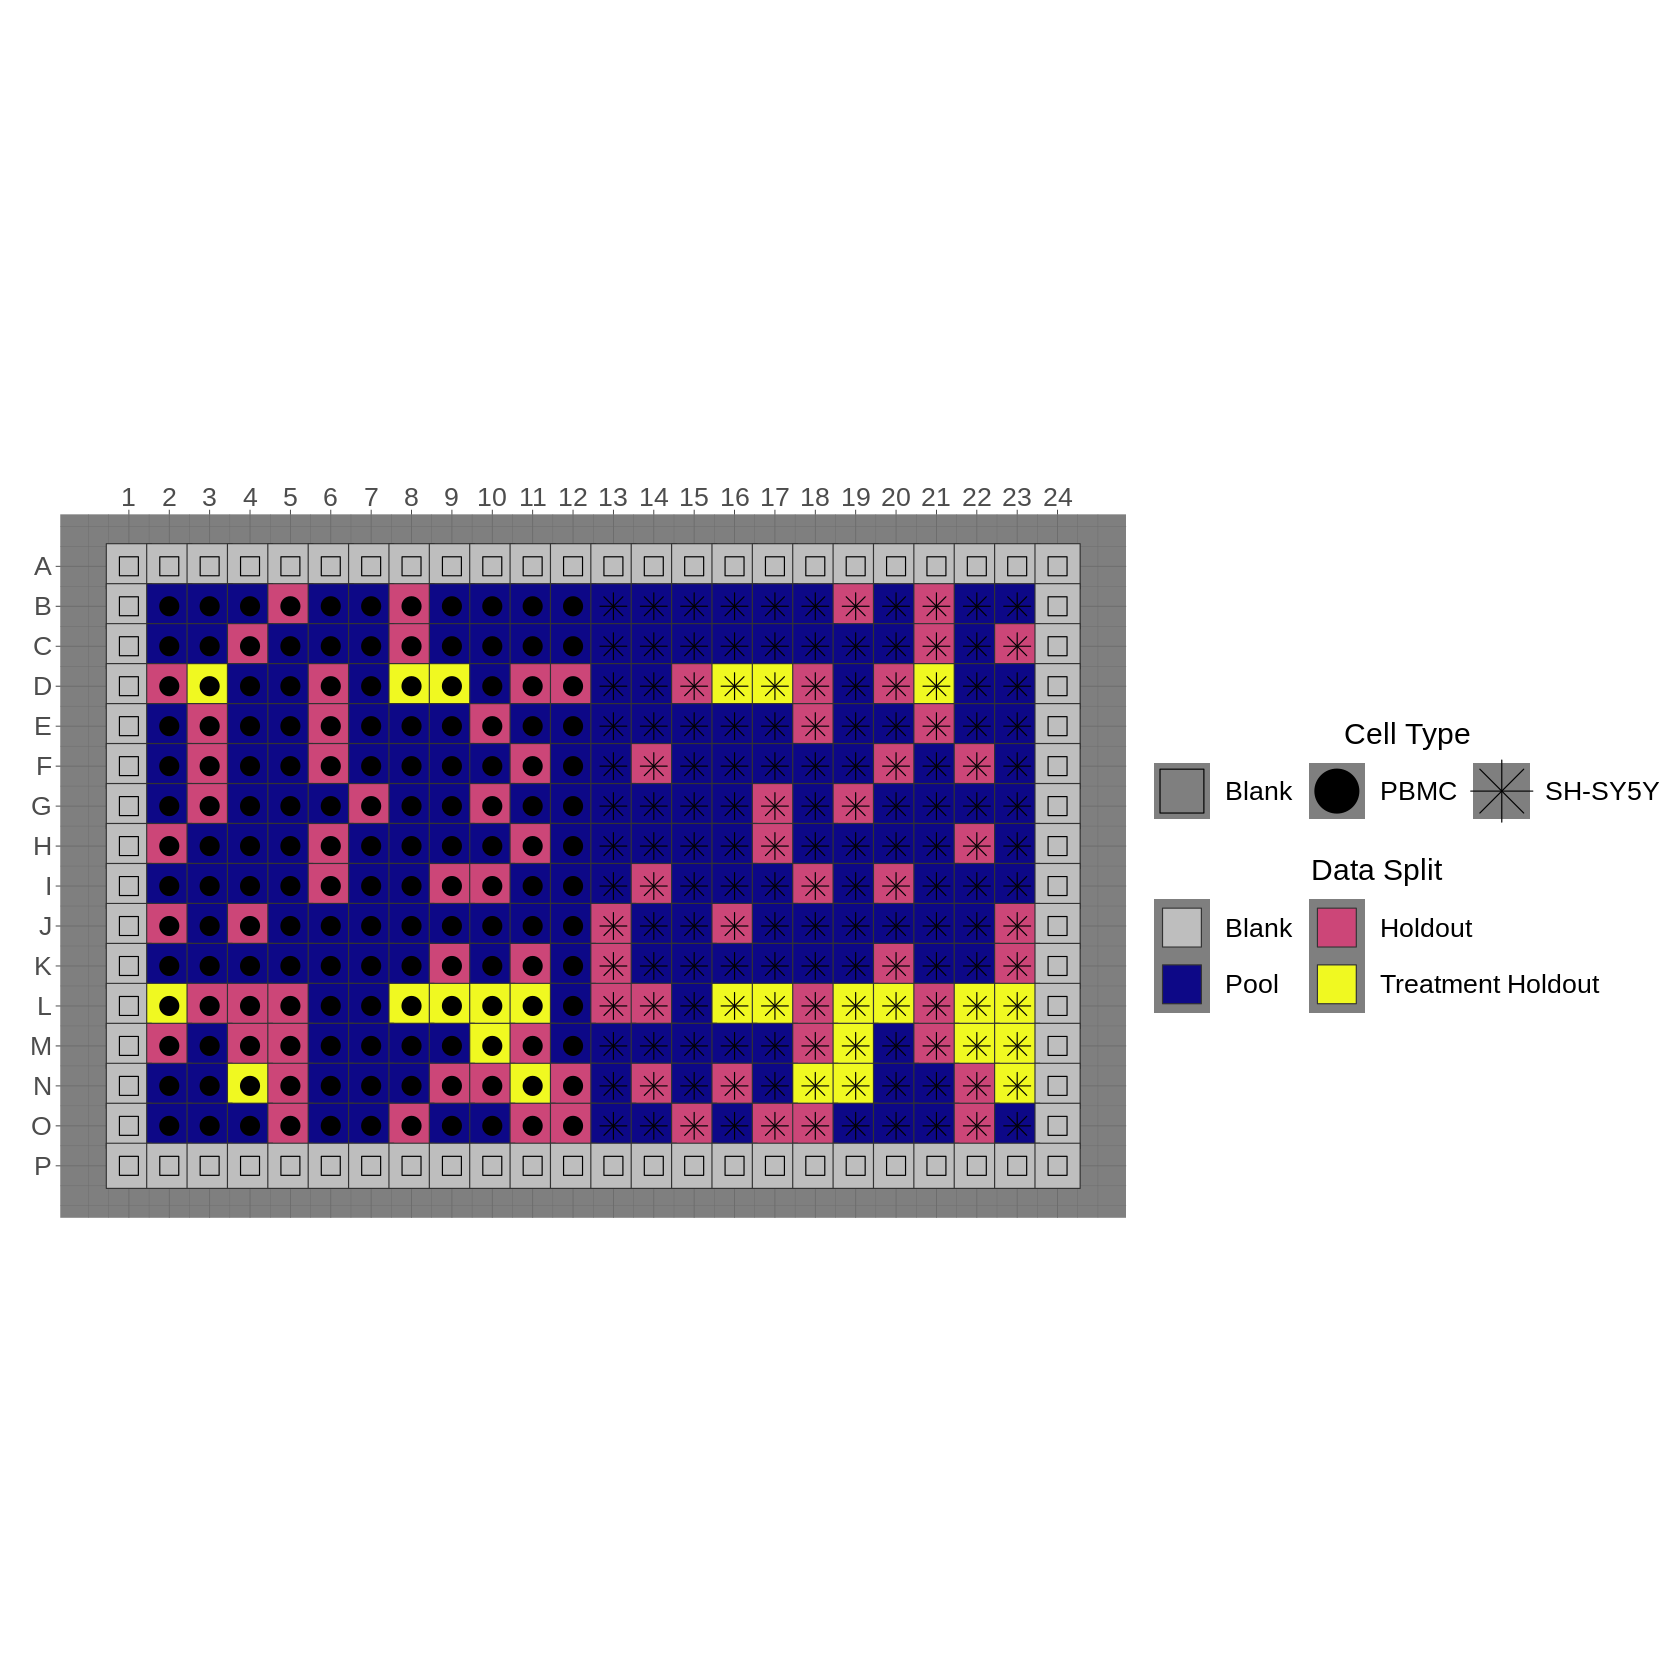

In [11]:
width <- 14
height <- 14
options(repr.plot.width = width, repr.plot.height = height, units = "cm")
# set pallette
viridis_pal_custom <- viridis::viridis_pal(option = "C")(3)

data_split_plate_map <- (
    raw_map(
        data = updated_platemap$label,
        well = updated_platemap$well_id,
        plate = 384,
        size = 14)
    + theme_dark()
        + ggplot2::geom_point(
        aes(shape = updated_platemap$Metadata_cell_type),
        size = 5
        )
        + labs(fill = "Data Split", shape = "Cell Type")
    # change legend text size for fill

    + guides(shape = guide_legend(override.aes = list(size = 12), nrow = 1))
    + guides(fill = guide_legend(override.aes = list(size = 12),ncol = 2))
    + theme(
        legend.title = element_text(size = 18,hjust = 0.5),
        legend.text = element_text(size = 16),
    )
    + scale_shape_manual(
        values = c(
            'Blank' = 0,
            'PBMC' = 19,
            'SH-SY5Y' = 8
        )
    )
    + scale_fill_manual(
    values = c(
        'Blank' = "grey",
        'Pool' = viridis_pal_custom[1],
        'Holdout' = viridis_pal_custom[2],
        'Treatment Holdout' = viridis_pal_custom[3]
        
    )
    )
    + theme(
        axis.text.x = element_text(size = 16),
        axis.text.y = element_text(size = 16)
    )

)
data_split_plate_map
ggsave(
    filename = "../figures/data_split_plate_map.png",
    plot = data_split_plate_map,
    width = width,
    height = height,
    units = "in",
    dpi = 600
)
